# Introduction

Ce notebook est la première partie du projet de segmentation de clients pour le site e-commerce de l'entreprise Olist. Il traite de la préparation et de l'exploration des données.

## Importations

Nous n'aurons besoin ici que quelques libraires de manipulation de datasets et de visualisation graphique.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import missingno as msno

Les données sont disponibles sur le site de Kaggle :<br>
https://www.kaggle.com/datasets/olistbr/brazilian-ecommerce
    
On trouvera notamment à cette adresse un graphique indiquant les schémas relationnels des différentes tables présentes sur la base de données. Il y a 9 tables au total.

In [2]:
customers_data = pd.read_csv("csv/olist_customers_dataset.csv")
orders_data = pd.read_csv("csv/olist_orders_dataset.csv")
order_items_data = pd.read_csv("csv/olist_order_items_dataset.csv")
order_payments_data = pd.read_csv("csv/olist_order_payments_dataset.csv")
order_reviews_data = pd.read_csv("csv/olist_order_reviews_dataset.csv")

Tables utilisées :
- `customers_data` : informations générales sur chaque client.
- `order_data` : informations générales sur chaque commande.
- `order_items_data` : informations sur les items de chaque commande.
- `order_payments_data` : information sur chaque paiement effectué.
- `order_reviews_data` : informations sur chaque review postée.

Tables écartées :
- `geolocation_data` : informations géographiques sur chaque client (difficiles à hiérarchiser).
- `products_data` : information sur les produits (difficiles à hiérarchiser ou à exploiter).
- `sellers_data` : informations sur les vendeurs (non pertinentes).
- `translation_data` : traduction des commentaires laissés par les clients en portugais.

## Fonctions utilitaires

On définit dans cette sous-section quelques fonctions utilitaires qui permettront de contrôler les opérations effectuées sur les jeux de données :
- Une fonction pour afficher les dimension d'un dataset.
- Une fonction pour compter les doublons dans une colonne d'un dataset.
- Une fonction pour compter les problèmes de concordance entre deux datasets.

In [3]:
def display_dimensions(df, df_name = None) :

    if df_name == None :
        print("Dimensions du dataset :")
    else :
        print(f"Dimensions du dataset {df_name} :")
    
    print("  -", df.shape[0], "lignes")
    print("  -", df.shape[1], "colonnes")

In [4]:
def display_duplicates(df, feature, df_name = None) :
    
    duplicates = df[df[feature].duplicated(keep = False)]

    if df_name == None :
        print(f"Nombre de doublons dans la colonne {feature} : "
              f"{duplicates.shape[0]}")
    else :
        print(f"Nombre de doublons dans la colonne {feature} "
              f"du dataset {df_name} : {duplicates.shape[0]}")

In [5]:
def display_mismatches(feature, df_1, df_2, name_1, name_2) :
    
    missing_1 = df_1[~df_1[feature].isin(df_2[feature])] 
    missing_2 = df_2[~df_2[feature].isin(df_1[feature])]
    
    print(f"Nombre de valeurs de '{feature}' dans '{name_1}' "
          f"qui n'apparaissent pas dans '{name_2}' : ", end = "")
    print(missing_1.shape[0])
    
    print(f"Nombre de valeurs de '{feature}' dans '{name_2}' "
          f"qui n'apparaissent pas dans '{name_1}' : ", end = "")
    print(missing_2.shape[0])

# Préparation des données

L'objectif de cette section est de construire un fichier clients avec des informations pertinentes pour la segmentation souhaitée.

On commence par fusionner les 5 tables à l'aide de jointures, pour obtenir une unique table contenant toutes les informations les commandes. Puis on construit le fichier client à partir de ces informations.



## Jointure des clients

La première jointure consiste à rattacher chaque commande au client qui l'a effectuée.<br>
Les colonnes `customer_id` des deux tables `orders_data` et `customers_data` coïncident parfaitement (clé primaire/étrangère), donc cette jointure ne pose pas de problème particulier.

In [6]:
display_dimensions(orders_data, "orders_data")

Dimensions du dataset orders_data :
  - 99441 lignes
  - 8 colonnes


In [7]:
display_dimensions(customers_data, "customers_data")

Dimensions du dataset customers_data :
  - 99441 lignes
  - 5 colonnes


In [8]:
display_duplicates(orders_data, "order_id", "orders_data")
display_duplicates(orders_data, "customer_id", "orders_data")
display_duplicates(orders_data, "customer_id", "customers_data")

Nombre de doublons dans la colonne order_id du dataset orders_data : 0
Nombre de doublons dans la colonne customer_id du dataset orders_data : 0
Nombre de doublons dans la colonne customer_id du dataset customers_data : 0


In [9]:
merged_data_1 = pd.merge(
    orders_data,
    customers_data,
    on = "customer_id"
)

In [10]:
display_dimensions(merged_data_1)

Dimensions du dataset :
  - 99441 lignes
  - 12 colonnes


## Jointure des reviews

La deuxième étape consiste à rattacher les informations de la table `order_reviews_data`.<br>
Cette fois, on verra que des problèmes d'unicité et de concordance sur la colonne de jointure `order_id` nécessitent de regarder plus en détails et de faire des choix.

In [11]:
display_dimensions(order_reviews_data, "order_reviews_data")

Dimensions du dataset order_reviews_data :
  - 99224 lignes
  - 7 colonnes


In [12]:
display_duplicates(order_reviews_data, "review_id", "order_reviews_data")
display_duplicates(order_reviews_data, "order_id", "order_reviews_data")

Nombre de doublons dans la colonne review_id du dataset order_reviews_data : 1603
Nombre de doublons dans la colonne order_id du dataset order_reviews_data : 1098


Le code ci-dessous révèle que les lignes ayant un `review_id` identiques ont exactement les mêmes valeurs sauf éventuellement pour leur `order_id`.<br>
Cela signifie qu'une même review peut avoir été attribuée à différentes commandes.

In [13]:
duplicated_reviews = (
    order_reviews_data[order_reviews_data["review_id"]
                      .duplicated(keep = False)]
)

count = 0

for review_id in duplicated_reviews["review_id"].unique() :
    rows = duplicated_reviews[duplicated_reviews["review_id"] == review_id]
    rows = rows.drop(["review_id", "order_id"], axis = 1)
    if any(rows[col].nunique() > 1 for col in rows.columns) :
        count += 1

print("Nombre de 'id_review' identiques dont les autres valeurs "
      "diffèrent ailleurs que pour 'order_id' :", count)

Nombre de 'id_review' identiques dont les autres valeurs diffèrent ailleurs que pour 'order_id' : 0


Les doublons dans les `order_id` du dataframe `order_reviews_data` concernent quant à eux des reviews successives postées par le client, pour rajouter un commentaire ou pour modifier la note.<br>
La jointure nécessitant l'unicité des `order_id`, il semble pertinent d'effectuer une agrégation qui conserve la review la plus récente.

In [14]:
# Trier par order_id (croissant) puis review_creation_date (décroissant)
order_reviews_sorted = order_reviews_data.sort_values(
    by = ["order_id", "review_creation_date"],
    ascending = [True, False]
)

# Grouper par order_id et sélectionner la première ligne de chaque groupe
order_reviews_grouped = (
    order_reviews_sorted.groupby("order_id")
    .first()
    .reset_index()
)

Vérifions maintenant s'il y a des valeurs de `order_id` présentes dans une seule des deux tables.

In [15]:
display_mismatches("order_id", order_reviews_grouped, orders_data,
                   "order_reviews_grouped", "orders_data")

Nombre de valeurs de 'order_id' dans 'order_reviews_grouped' qui n'apparaissent pas dans 'orders_data' : 0
Nombre de valeurs de 'order_id' dans 'orders_data' qui n'apparaissent pas dans 'order_reviews_grouped' : 768


Il n'y a pas de code commande erroné (review associée à une commande inexistante).<br>
Il y a en revanche plusieurs commandes sans review : on les conserve pour l'instant dans la jointure en remplissant de NaN.

In [16]:
merged_data_2 = pd.merge(
    merged_data_1,
    order_reviews_grouped,
    on = "order_id",
    how = "left"
)

In [17]:
display_dimensions(merged_data_2)

Dimensions du dataset :
  - 99441 lignes
  - 18 colonnes


## Jointure des paiements

La troisième étape consiste à rattacher les informations de la table `order_payments_data`.<br>
On observe des problèmes semblables à ceux de la jointure précédente.

In [18]:
display_dimensions(order_payments_data, "order_payments_data")

Dimensions du dataset order_payments_data :
  - 103886 lignes
  - 5 colonnes


In [19]:
display_duplicates(order_payments_data, "order_id", "order_payments_data")

Nombre de doublons dans la colonne order_id du dataset order_payments_data : 7407


Les `order_id` qui apparaissent plusieurs fois correspondent à des paiements fractionnés en différents modes de versement, principalement un mélange de coupons de réduction et d'une carte de crédit.

Comme la jointure nécessite l'unicité de `order_id`, on effectue une agrégation de la façon suivante :
- Une somme pour les colonnes `payment_installments` et `payment_value`.
- Un abandon pour les colonnes `payment_sequential` et `payment_type`.

In [20]:
# Trier les lignes par 'order_id'
order_payments_sorted = order_payments_data.sort_values(by = "order_id")

# Abandonner les colonnes 'payment_sequential' et 'payment_type'
order_payments_sorted = order_payments_sorted.drop(
    ["payment_sequential", "payment_type"],
    axis = 1
)

# Agréger sur 'order_id' en sommant 'payment_installments' et 'payment_value'
order_payments_grouped = order_payments_sorted.groupby(['order_id']).agg({
    'payment_installments': 'sum',
    'payment_value': 'sum'
}).reset_index()

In [21]:
display_dimensions(order_payments_grouped)

Dimensions du dataset :
  - 99440 lignes
  - 3 colonnes


In [22]:
display_mismatches("order_id", order_payments_data, orders_data,
                   "order_payments_data", "order_data")

Nombre de valeurs de 'order_id' dans 'order_payments_data' qui n'apparaissent pas dans 'order_data' : 0
Nombre de valeurs de 'order_id' dans 'order_data' qui n'apparaissent pas dans 'order_payments_data' : 1


Il n'y a pas de code commande erroné dans la liste des paiements.<br>
Une seule commande n'a pas de paiement associé : on la converse pour l'instant en mettant des NaN.

In [23]:
merged_data_3 = pd.merge(
    merged_data_2,
    order_payments_grouped,
    on = "order_id",
    how = "left"
)

In [24]:
display_dimensions(merged_data_3)

Dimensions du dataset :
  - 99441 lignes
  - 20 colonnes


## Nombre d'items par commande

Le quatrième et dernière étape consiste à rattacher la table `order_items_data`.<br>
Les informations sur chaque item (détails sur le produit ou sur le vendeur) ne nous intéressent pas.<br>
On se contente de compter le nombre d'items par commande et de l'ajouter dans une nouvelle colonne.

In [25]:
display_dimensions(order_items_data, "order_items_data")

Dimensions du dataset order_items_data :
  - 112650 lignes
  - 7 colonnes


In [26]:
display_duplicates(order_items_data, "order_id", "order_items_data")

Nombre de doublons dans la colonne order_id du dataset order_items_data : 23787


In [27]:
display_mismatches("order_id", order_items_data, orders_data,
                   "order_items_data", "order_data")

Nombre de valeurs de 'order_id' dans 'order_items_data' qui n'apparaissent pas dans 'order_data' : 0
Nombre de valeurs de 'order_id' dans 'order_data' qui n'apparaissent pas dans 'order_items_data' : 775


In [28]:
# Compter le nombre d'items par order_id dans order_items_data
item_counts = (
    order_items_data
    .groupby("order_id")
    .size()
    .reset_index(name="items")
)

# Ajouter la colonne 'items' au dataframe principal
merged_orders_data = pd.merge(
    merged_data_3,
    item_counts,
    on = "order_id",
    how = "left"
)

In [29]:
display_dimensions(merged_orders_data, "merged_orders_data")

Dimensions du dataset merged_orders_data :
  - 99441 lignes
  - 21 colonnes


## Construction de la table client

On peut maintenant, à partir de toutes ces informations rassemblées sur les commandes, construire un fichier clients en sélectionnant les features pertinentes.

Features sélectionnées :
- `customer_id` est l'identifiant du client sur le site (initialement la colonne `customer_unique_id`).
- `orders` est le nombre de commandes effectuées par le client
- `items` est le nombre total d'items achetés par le client sur l'ensemble de ses commandes.
- `total_bill` est le montant total versé par le client sur l'ensemble de ses commandes.
- `average_review` est la note moyenne attribuée par le client sur l'ensemble de ses commandes.
- `first_order_date` est la date de la première commande du client
- `last_order_date` est la date de la dernière commande du client
- `delivery_time` est le temps moyen de livraison sur l'ensemble des commandes
- `estimated_delivery_time` est la moyenne des estimations du temps de livraison données sur l'ensemble des commandes.

On convertit les colonnes de dates au format datetime.

In [30]:
data = merged_orders_data.copy()

date_features = ["order_purchase_timestamp", "order_delivered_customer_date",
                 "order_estimated_delivery_date"]

for feature in date_features :
    data[feature] = pd.to_datetime(data[feature])

On ajoute une colonne `delivered` indiquant si la colonne a été délivrée, puis on calcule les temps de livraison réels `delivery_time` et les temps de livraison estimés `delivery_delay`.

In [31]:
data["delivered"] = (data["order_status"] == "delivered").astype(int)
    
data["delivery_time"] = (
    data["order_delivered_customer_date"] - data["order_purchase_timestamp"]
).dt.days

data["delivery_delay"] = (
    data["order_delivered_customer_date"] - data["order_estimated_delivery_date"]
).dt.days

On agrège les commandes par `customer_id` avec les opérations adéquates.

In [32]:
data = data.groupby("customer_unique_id").agg({
    "order_id": "count",
    "items": "sum",
    "payment_value": "sum",
    "review_score": "mean",
    "order_purchase_timestamp": ["min", "max"],
    "delivered": "mean",
    "delivery_time": "mean",
    "delivery_delay": "mean"
}).reset_index()
    
# Par défaut 'items' sera un flottant : conversion en entier
data["items"] = data["items"].astype("int64")

# Renommer les colonnes
data.columns = ["customer_id", "orders", "items", "total_bill",
                "average_review", "first_order_date",
                "last_order_date", "delivered",
                "average_delivery_time", "average_delivery_delay"]

# Analyse exploratoire

Maintenant que le fichier client est construit, on peut explorer les données pour en apprendre davantage.

## Aperçu rapide

In [33]:
data.head()

,customer_id,orders,items,total_bill,average_review,first_order_date,last_order_date,delivered,average_delivery_time,average_delivery_delay
0,0000366f3b9a7992bf8c76cfdf3221e2,1,1,141.90,5.0,2018-05-10 10:56:27,2018-05-10 10:56:27,1.0,6.0,-5.0
1,0000b849f77a49e4a4ce2b2a4ca5be3f,1,1,27.19,4.0,2018-05-07 11:11:27,2018-05-07 11:11:27,1.0,3.0,-5.0
2,0000f46a3911fa3c0805444483337064,1,1,86.22,3.0,2017-03-10 21:05:03,2017-03-10 21:05:03,1.0,25.0,-2.0
3,0000f6ccb0745a6a4b88665a16c9f078,1,1,43.62,4.0,2017-10-12 20:29:41,2017-10-12 20:29:41,1.0,20.0,-12.0
4,0004aac84e0df4da2b147fca70cf8255,1,1,196.89,5.0,2017-11-14 19:45:42,2017-11-14 19:45:42,1.0,13.0,-8.0


In [34]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 96096 entries, 0 to 96095
Data columns (total 10 columns):
 #   Column                  Non-Null Count  Dtype         
---  ------                  --------------  -----         
 0   customer_id             96096 non-null  object        
 1   orders                  96096 non-null  int64         
 2   items                   96096 non-null  int64         
 3   total_bill              96096 non-null  float64       
 4   average_review          95380 non-null  float64       
 5   first_order_date        96096 non-null  datetime64[ns]
 6   last_order_date         96096 non-null  datetime64[ns]
 7   delivered               96096 non-null  float64       
 8   average_delivery_time   93356 non-null  float64       
 9   average_delivery_delay  93356 non-null  float64       
dtypes: datetime64[ns](2), float64(5), int64(2), object(1)
memory usage: 7.3+ MB


<Axes: >

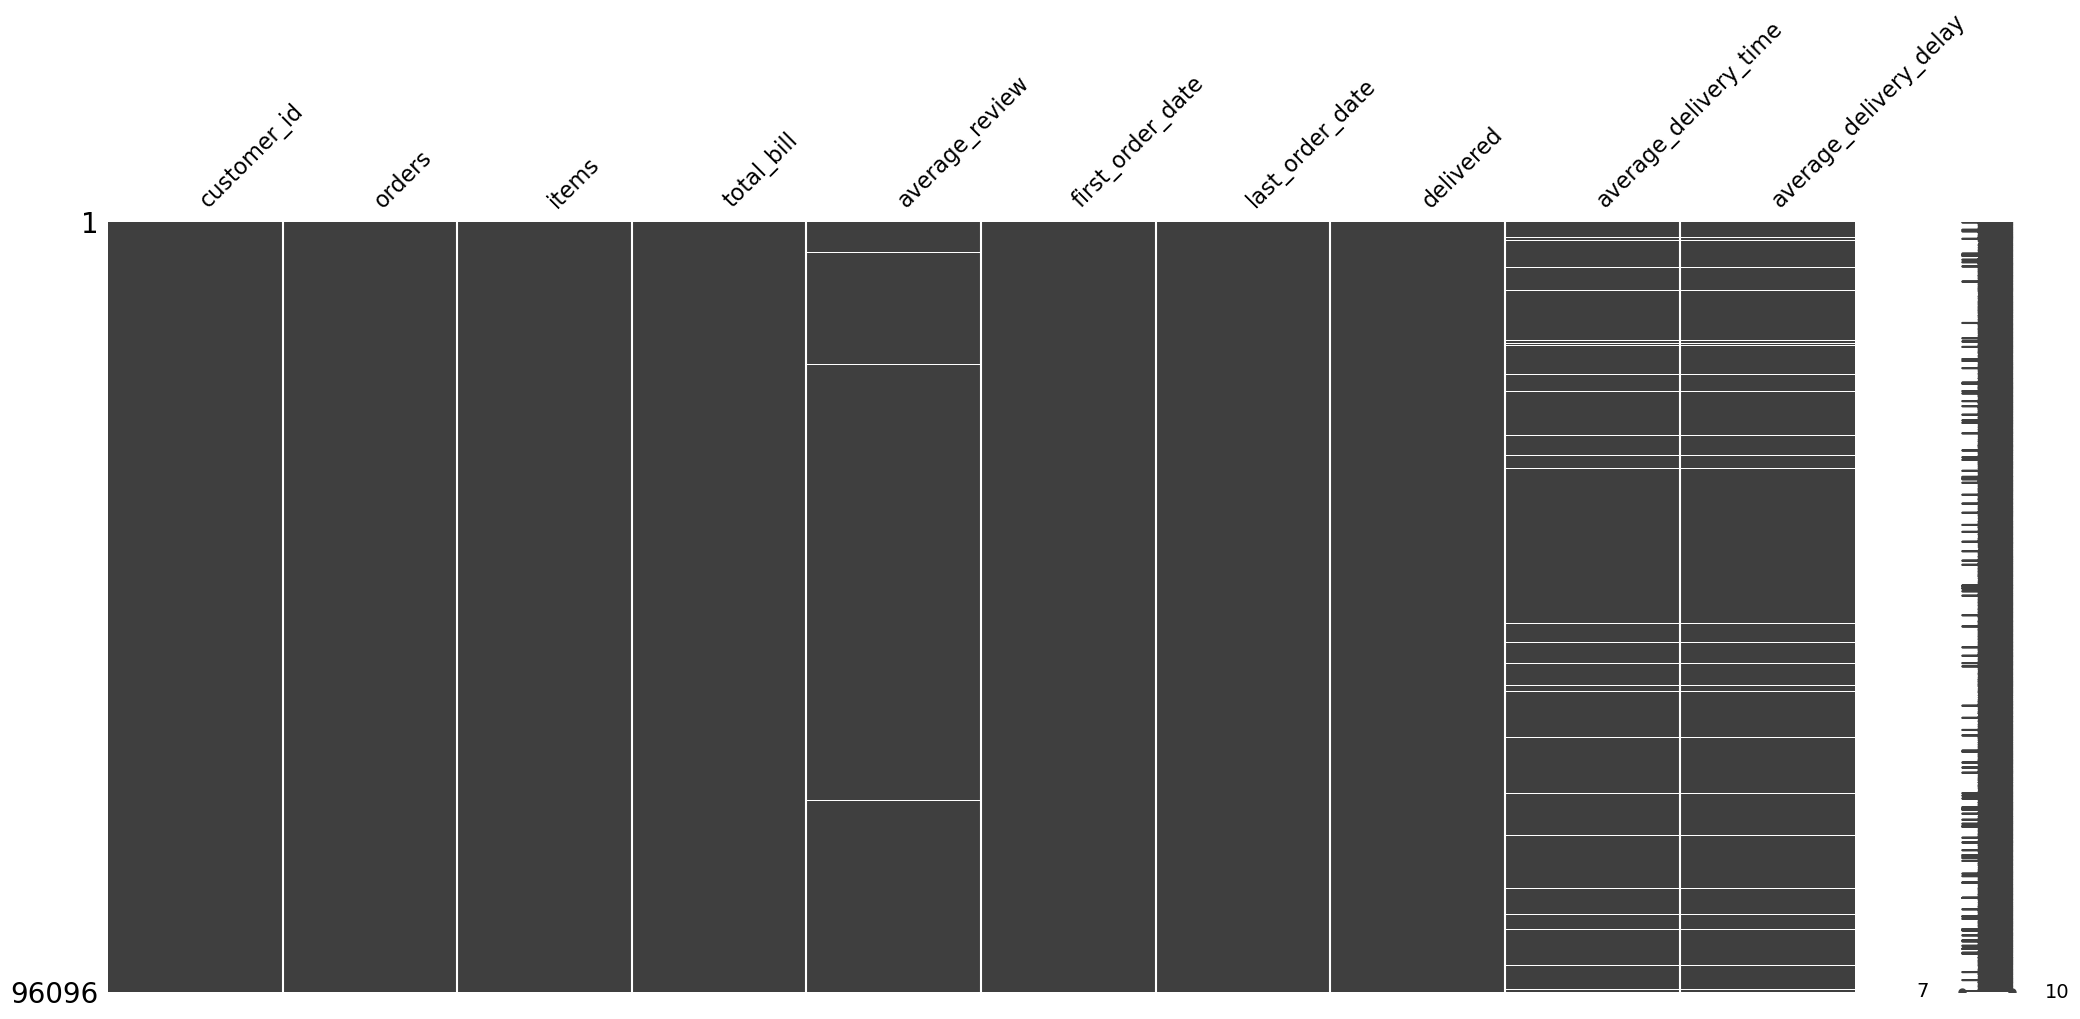

In [35]:
msno.matrix(data)

Il y a très peu de valeurs manquantes, et seulement dans les colonnes `average_review`, `average_delivery_time` et `average_delivery_delay`. On peut au choix supprimer les lignes correspondantes ou réaliser des imputations.

In [36]:
data_cleaned = data.dropna()
display_dimensions(data_cleaned)

Dimensions du dataset :
  - 92753 lignes
  - 10 colonnes


In [37]:
data_cleaned.describe()

,orders,items,total_bill,average_review,first_order_date,last_order_date,delivered,average_delivery_time,average_delivery_delay
count,92753.000000,92753.000000,92753.000000,92753.000000,92753,92753,92753.000000,92753.000000,92753.000000
mean,1.035751,1.181072,165.377034,4.152010,2018-01-01 12:53:37.218375680,2018-01-04 08:27:55.339913728,0.998897,12.063496,-11.885338
min,1.000000,1.000000,0.000000,1.000000,2016-09-15 12:16:38,2016-09-15 12:16:38,0.000000,0.000000,-147.000000
25%,1.000000,1.000000,63.100000,4.000000,2017-09-13 15:20:19,2017-09-17 22:36:58,1.000000,6.000000,-17.000000
50%,1.000000,1.000000,107.850000,5.000000,2018-01-20 10:40:15,2018-01-23 11:57:17,1.000000,10.000000,-12.000000
75%,1.000000,1.000000,182.690000,5.000000,2018-05-05 16:36:29,2018-05-07 20:23:58,1.000000,15.000000,-7.000000
max,17.000000,24.000000,13664.080000,5.000000,2018-08-29 15:00:37,2018-10-16 20:16:02,1.000000,208.000000,188.000000
std,0.217344,0.619478,227.829035,1.281177,NaN,NaN,0.023998,9.466743,10.070662


## Visualition des distributions

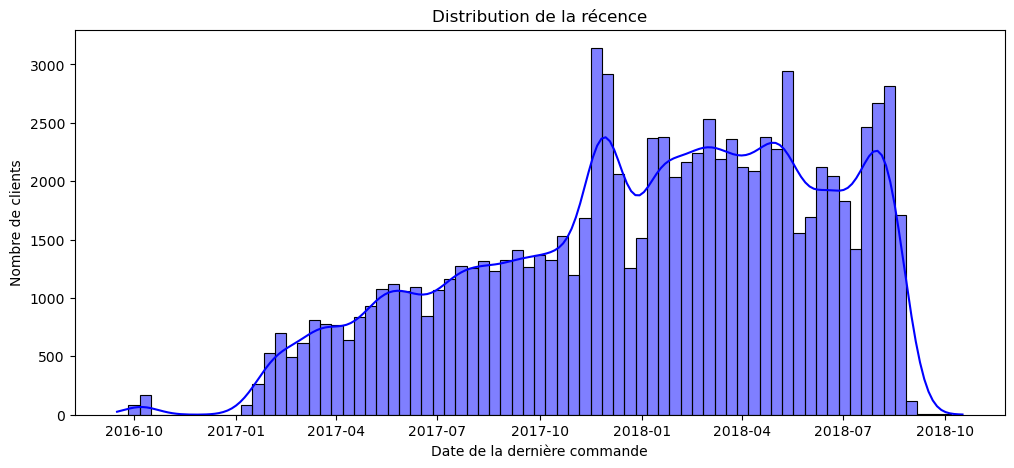

In [38]:
plt.figure(figsize = (12, 5))

sns.histplot(data_cleaned["last_order_date"],
             kde = True,
             color = 'blue',
             edgecolor = 'black')

plt.title(f"Distribution de la récence")
plt.xlabel("Date de la dernière commande")
plt.ylabel('Nombre de clients')
plt.show()

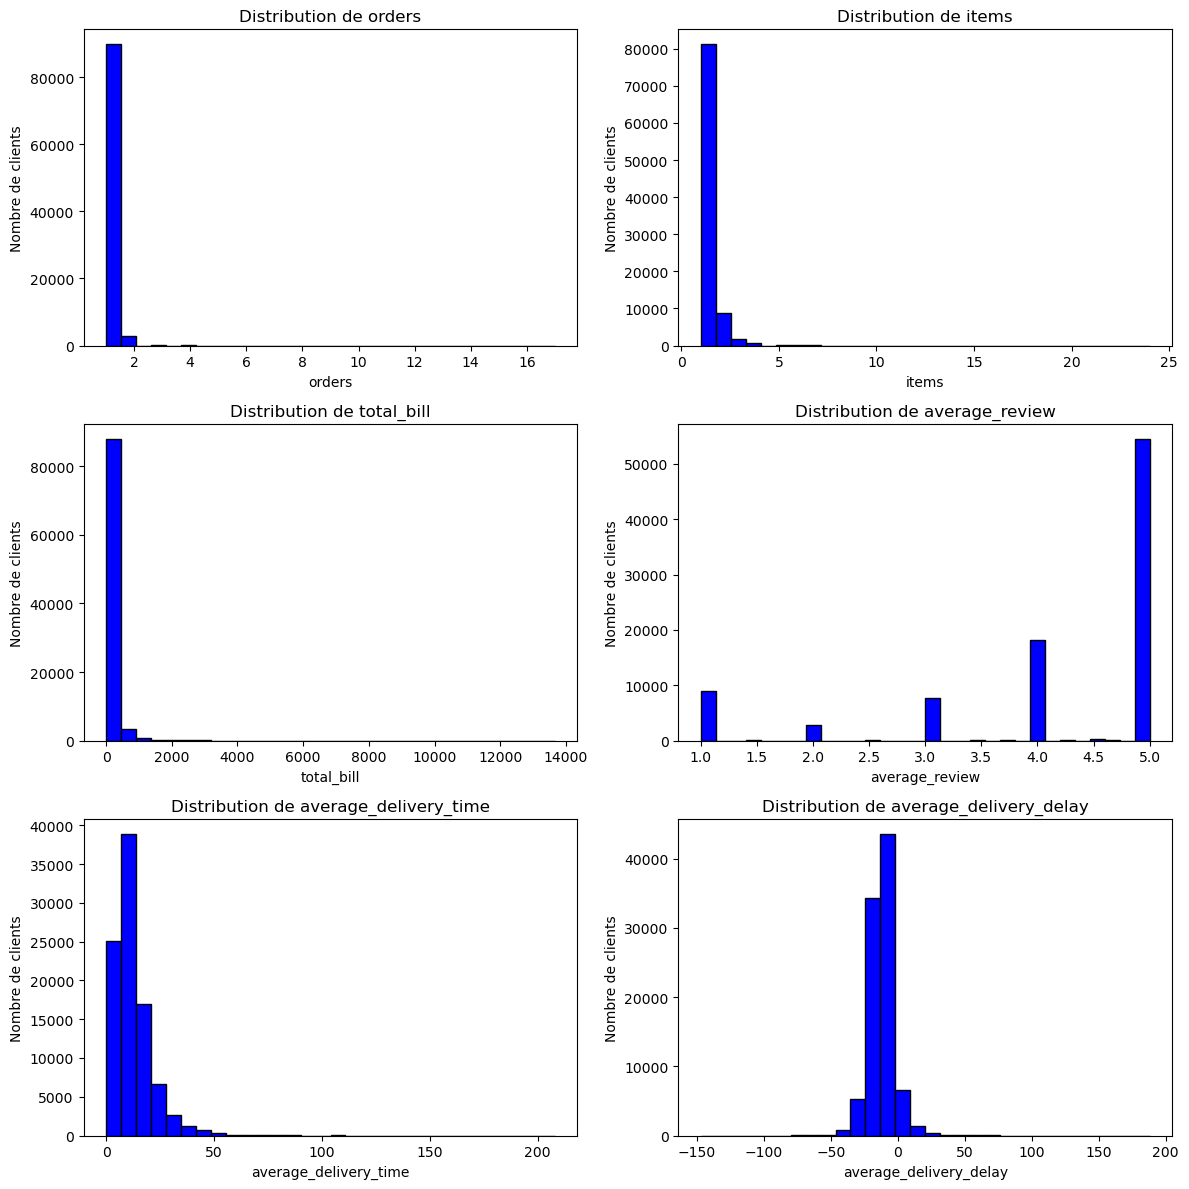

In [39]:
numeric_columns = ["orders", "items", "total_bill", "average_review",
                   "average_delivery_time", "average_delivery_delay"]

fig, axes = plt.subplots(3, 2, figsize = (12, 12))

for (i, column) in enumerate(numeric_columns) :
    
    (row, col) = (i // 2, i % 2)
    
    axes[row, col].hist(data_cleaned[column],
                        bins = 30,
                        color = 'blue',
                        edgecolor = 'black')
    
    axes[row, col].set_title(f'Distribution de {column}')
    axes[row, col].set_xlabel(column)
    axes[row, col].set_ylabel('Nombre de clients')

plt.tight_layout()
plt.show()

Une transformation logarithmique sur `total_bill` et `average_delivery_time` semble pertinente.

In [40]:
def log_transform(input_df, features) :
    
    df = input_df.copy()
    
    for feature in features :
        df[feature + "_log"] = np.log1p(df[feature])
    
    df = df.drop(features, axis = 1)

    return df

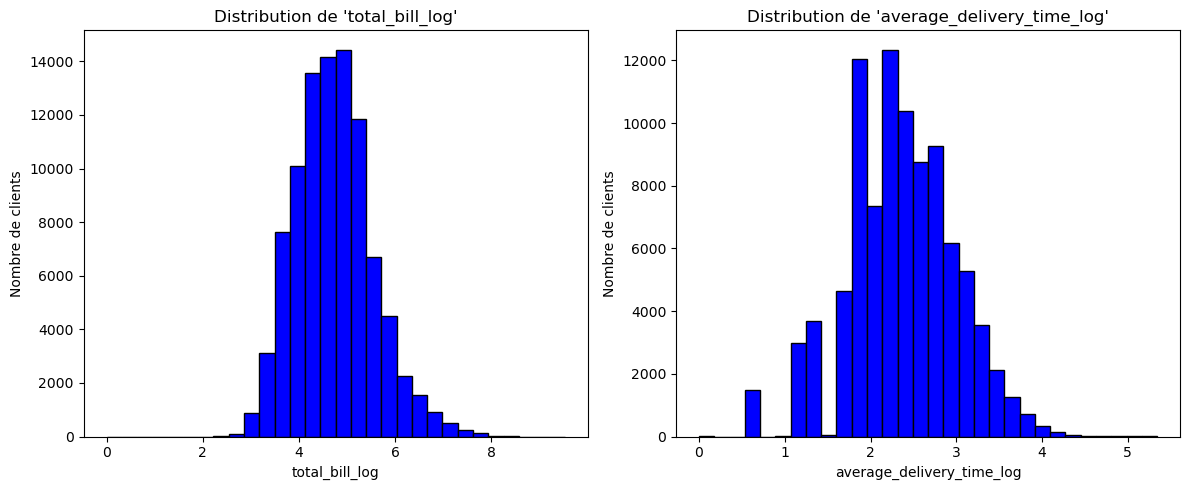

In [41]:
log_features = ["total_bill", "average_delivery_time"]
data_log = log_transform(data_cleaned, log_features)

fig, axes = plt.subplots(1, 2, figsize = (12, 5))

for col in range(2) :
    
    feature = log_features[col] + "_log"
    
    axes[col].hist(data_log[feature],
                      bins = 30,
                      color = 'blue',
                      edgecolor = 'black')
    
    axes[col].set_title(f"Distribution de '{feature}'")
    axes[col].set_xlabel(feature)
    axes[col].set_ylabel("Nombre de clients")

plt.tight_layout()
plt.show()

In [42]:
percentage = (data["orders"] > 1).mean() * 100
print(f"Pourcentage de clients ayant fait plus d'une commande : {percentage:.2f}%")

Pourcentage de clients ayant fait plus d'une commande : 3.12%


Comme Olist l'avait précisé, très peu de clients ont réalisé plus d'une commande.<br>
On propose de placer ces clients dans une catégorie à part et d'effectuer la segmentation sur le reste.

## Traitement supplémentaire

Ce choix d'effectuer la segmentation seulement sur les clients ayant une seule commande a quelques conséquences sur le dataset :
- Les colonnes `orders` et `first_order_date` ne sont plus nécessaires.
- La colonne `delivered` n'est plus qu'un simple booléen (0 ou 1).
- Les colonnes `average_review`, `average_delivery_time` et `average_delivery_delay` ne sont plus vraiment des moyennes.

In [43]:
# Ecarter les clients ayant plus d'une commande
data_seg = data[data["orders"] == 1].copy()

# Retirer les colonnes devenues inutiles
data_seg = data_seg.drop(["orders", "first_order_date"], axis = 1)

# Renommer les colonnes
data_seg = data_seg.rename(columns = {
    "average_review" : "review",
    "average_delivery_time" : "delivery_time",
    "average_delivery_delay" : "delivery_delay",
    "last_order_date" : "order_date",
    "total_bill" : "bill"
})

# Transformations logarithmiques
data_seg = log_transform(data_seg, ["bill", "delivery_time"])

On choisit pour la segmentation d'écarter les clients dont la commande n'a pas été délivrée.

In [44]:
count = data_seg["delivered"].value_counts().get(0, 0)
print(f"Ratio de commandes non délivrées : {count} / {len(data_seg)}")

Ratio de commandes non délivrées : 2720 / 93099


In [45]:
data_seg = data_seg[data_seg["delivered"] == 1].copy()
data_seg = data_seg.drop(["delivered"], axis = 1)

On ne souhaite en revanche pas abandonner les clients dont certaines valeurs sont manquantes (notamment la review). On propose donc une imputation par la médiane ou la moyenne.

In [46]:
for feature in ["review", "delivery_time_log", "delivery_delay"] :
    missing_count = data_seg[feature].isnull().sum()
    print(f"Nombre de valeurs manquantes dans '{feature}' : {missing_count}")

Nombre de valeurs manquantes dans 'review' : 594
Nombre de valeurs manquantes dans 'delivery_time_log' : 8
Nombre de valeurs manquantes dans 'delivery_delay' : 8


In [47]:
# Imputation de la colonne "delivery_time_log" par la moyenne
mean_delivery_time = data_seg["delivery_time_log"].mean()
data_seg["delivery_time_log"].fillna(mean_delivery_time, inplace = True)

# Imputation de la colonne "delivery_time" par la moyenne
mean_delivery_delay = data_seg["delivery_delay"].mean()
data_seg["delivery_delay"].fillna(mean_delivery_delay, inplace = True)

# Imputation de la colonne "review" par la médiane
median_review = data_seg["review"].median()
data_seg["review"].fillna(median_review, inplace = True)

# Conversion la colonne "review" en entier
data_seg["review"] = data_seg["review"].astype(int)

data_seg.head()

,customer_id,items,review,order_date,delivery_delay,bill_log,delivery_time_log
0,0000366f3b9a7992bf8c76cfdf3221e2,1,5,2018-05-10 10:56:27,-5.0,4.962145,1.945910
1,0000b849f77a49e4a4ce2b2a4ca5be3f,1,4,2018-05-07 11:11:27,-5.0,3.338967,1.386294
2,0000f46a3911fa3c0805444483337064,1,3,2017-03-10 21:05:03,-2.0,4.468434,3.258097
3,0000f6ccb0745a6a4b88665a16c9f078,1,4,2017-10-12 20:29:41,-12.0,3.798182,3.044522
4,0004aac84e0df4da2b147fca70cf8255,1,5,2017-11-14 19:45:42,-8.0,5.287711,2.639057


Enregistrons ce dataset afin de pouvoir l'utiliser dans les notebooks suivants (segmentation).

In [48]:
data_seg.to_csv("csv/segmentation_dataset.csv", index = False)

# Uniformisation des données

Les algorithmes de clustering non supervisés se basent sur une notion de distance et il est important que toutes les features (toutes numériques ici) soient à le même échelle.

On propose 4 stratégies différentes d'uniformisation.

## Standardisation

Les distributions sont standardisées : moyennes ramenées à 0 et écarts-type ramenés à 1.

In [49]:
def standardize(input_df, features) :
    
    output_df = input_df.copy()
    
    for feature in features :
        mean = output_df[feature].mean()
        std = output_df[feature].std()
        output_df[feature] = (output_df[feature] - mean) / std

    return output_df

In [50]:
selected_features = ["bill_log", "review", "order_date", "items",
                     "delivery_time_log", "delivery_delay"]

df_1 = standardize(data_seg, selected_features)

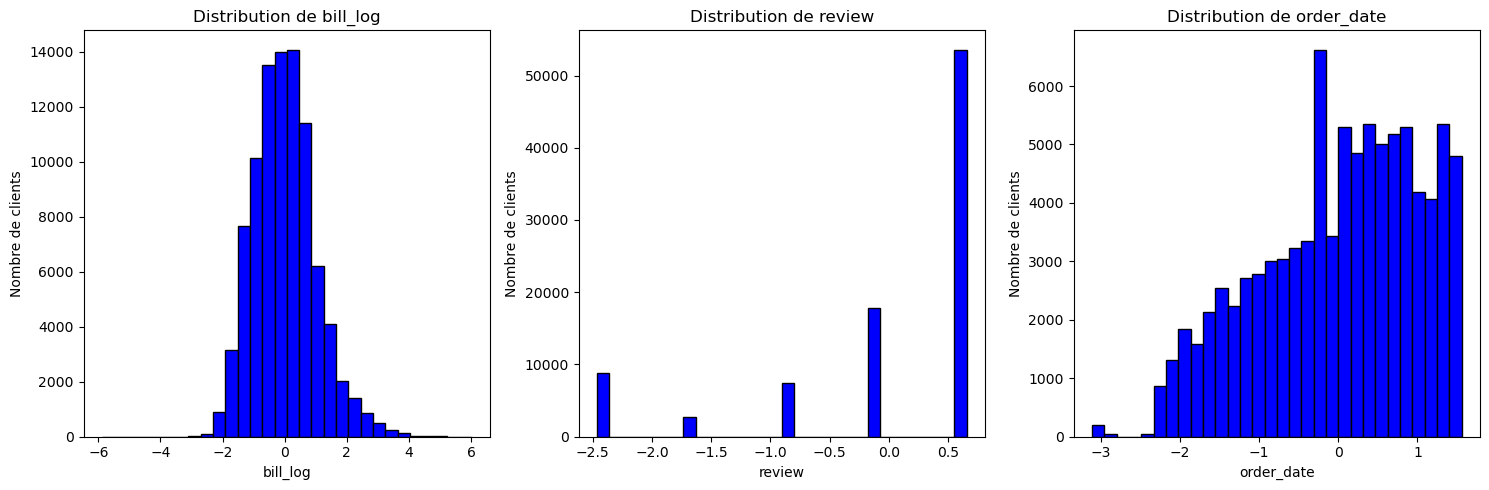

In [51]:
features_to_display = ["bill_log", "review", "order_date"]

fig, axes = plt.subplots(1, 3, figsize = (15, 5))

for i, feature in enumerate(features_to_display) :
    
    axes[i].hist(df_1[feature],
                 bins = 30,
                 color = 'blue',
                 edgecolor = 'black')
    
    axes[i].set_title(f'Distribution de {feature}')
    axes[i].set_xlabel(feature)
    axes[i].set_ylabel('Nombre de clients')

plt.tight_layout()
plt.show()

## Normalisation

Les distributions sont normalisées : valeurs ramenées entre 0 et 1.

In [52]:
def normalize(input_df, features) :
    
    output_df = input_df.copy()
    
    for feature in features :
        min_val = output_df[feature].min()
        range_val = output_df[feature].max() - min_val
        output_df[feature] = (output_df[feature] - min_val) / range_val
    
    return output_df

In [53]:
df_2 = normalize(data_seg, selected_features)

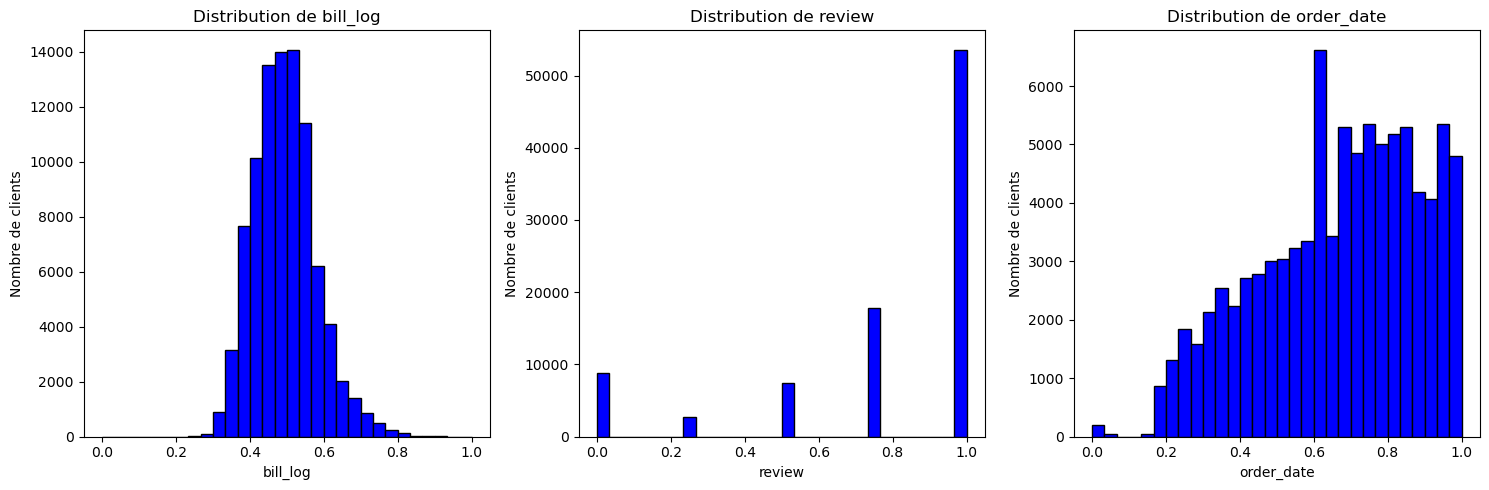

In [54]:
fig, axes = plt.subplots(1, 3, figsize = (15, 5))

for i, feature in enumerate(features_to_display) :
    
    axes[i].hist(df_2[feature],
                 bins = 30,
                 color = 'blue',
                 edgecolor = 'black')
    
    axes[i].set_title(f'Distribution de {feature}')
    axes[i].set_xlabel(feature)
    axes[i].set_ylabel('Nombre de clients')

plt.tight_layout()
plt.show()

## Subdivision

Les plages de valeurs sont subdivisées en *n* classes de même taille.<br>
Pour coïncider avec le fait que les reviews sont des notes de 1 à 5, on prend *n = 5*. 

In [55]:
def subdivide(input_df, features, bins) :
    
    output_df = input_df.copy()

    for feature in features :
        
        min_value = output_df[feature].min()
        max_value = output_df[feature].max()
        bin_width = (max_value - min_value) / bins
        bin_edges = [min_value + i * bin_width for i in range(bins + 1)]
                
        output_df[feature] = pd.cut(
            output_df[feature],
            bins = bin_edges,
            labels = False,
            include_lowest = True,
            duplicates = "drop"
        )

    return output_df

In [56]:
df_3 = subdivide(data_seg, selected_features, bins = 5)

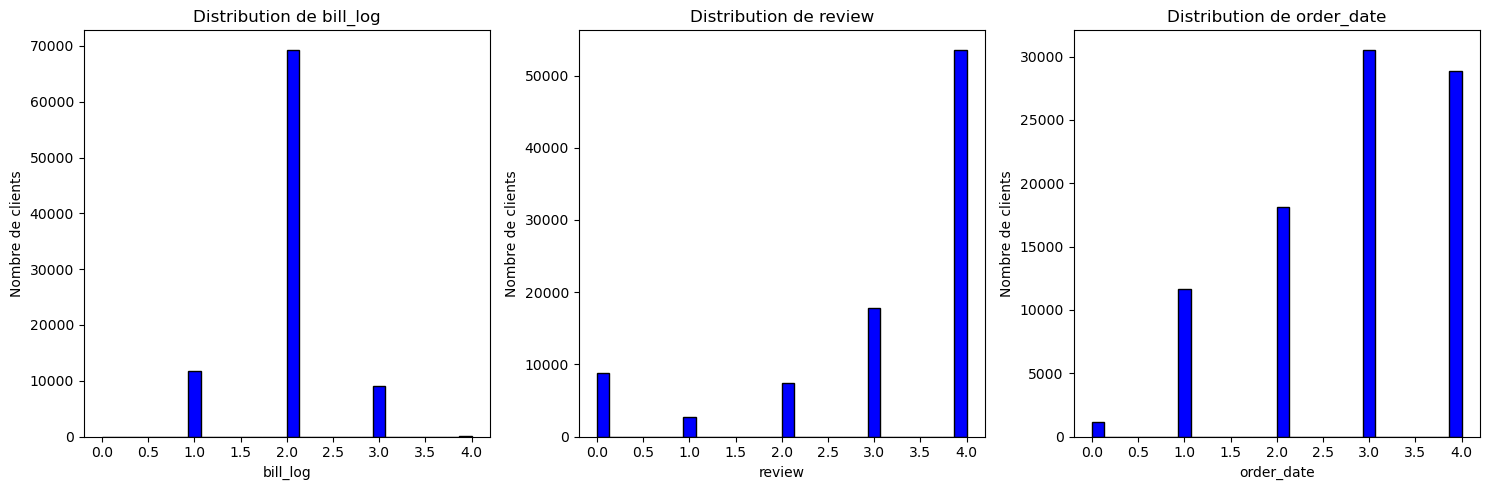

In [57]:
fig, axes = plt.subplots(1, 3, figsize = (15, 5))

for i, feature in enumerate(features_to_display) :
    
    axes[i].hist(df_3[feature],
                 bins = 30,
                 color = 'blue',
                 edgecolor = 'black')
    
    axes[i].set_title(f'Distribution de {feature}')
    axes[i].set_xlabel(feature)
    axes[i].set_ylabel('Nombre de clients')

plt.tight_layout()
plt.show()

## Quantilisation

Les distributions sont réparties en *n* catégories de même effectif (quantiles).<br>
Pour coïncider avec le fait que les reviews sont des notes de 1 à 5, on prend *n = 5*.<br>
On n'effectue cependant pas la quantilisation sur les reviews elles-mêmes (distribution discrète).

In [58]:
def quantilize(input_df, features, bins) :
    
    output_df = input_df.copy()
    
    for feature in features :
        
        quantiles = [i / bins for i in range(bins + 1)]
        
        output_df[feature] = pd.qcut(
            output_df[feature],
            quantiles,
            labels = False,
            duplicates = "drop"
        )
    
    return output_df

In [59]:
selected_features.remove("review")

df_4 = quantilize(data_seg, selected_features, bins = 5)
df_4["review"] = df_4["review"] - 1

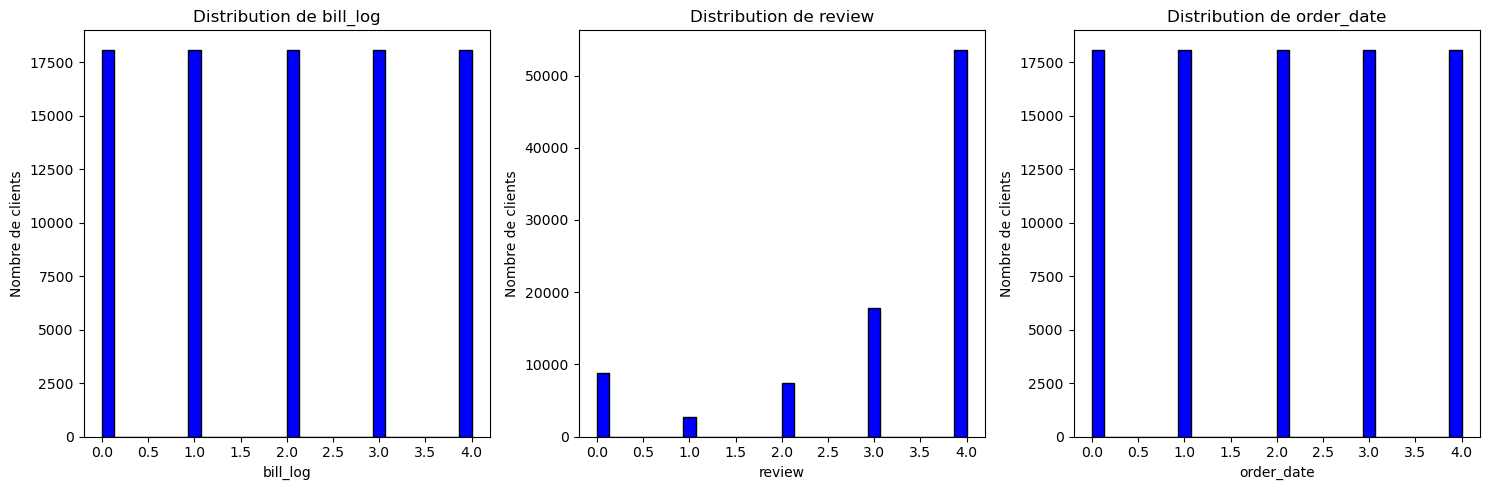

In [60]:
fig, axes = plt.subplots(1, 3, figsize = (15, 5))

for i, feature in enumerate(features_to_display) :
    
    axes[i].hist(df_4[feature],
                 bins = 30,
                 color = 'blue',
                 edgecolor = 'black')
    
    axes[i].set_title(f'Distribution de {feature}')
    axes[i].set_xlabel(feature)
    axes[i].set_ylabel('Nombre de clients')

plt.tight_layout()
plt.show()